**Author**: Elizabeth Martin </br>
**Title**: Final Project: Airbus Tweet Sentiment Analysis </br>
**Date**: Feb. 2nd, 2024

## Project description: Airbus tweet sentiment analysis

For my project, I will be using a dataset of tweets regarding various airlines and analyzing the sentiment of the tweet. After some exploratory data anlysis, preprocessing, and cleaning, I planto extract the relevant features with TF-IDF, model the topics with NMF, and try a few different clustering methods.

- Citation: https://www.kaggle.com/competitions/airbus-finance-ml-workshop/overview
- Github: https://github.com/Elizabeth-Martin2/machine-learning/tree/main/airbus

**Table of Contents:**
* [Step 1: Exploratory Data Analysis](#Step-1:-Eploratory-Data-Analysis)
* [Step 2: Model creation & evaluation](#Step-2:-Model-creation-&-evaluation)
* [Bonus: Compare with supervised learning method](#Bonus:-Compare-with-supervised-learning-method)
* [Summary & Conclusion](#Summary-&-Conclusion)
* [Citations](#Citations)

## Step 1: Exploratory Data Analysis

In [1]:
# ------ Exploratory data analysis ------ #
import pandas as pd
import matplotlib.pyplot as plt 
import re

from nltk.corpus import stopwords
from wordcloud import WordCloud # for creating word clouds / text analysis
# --------------------------------------- #

# ---------- Feature Extraction --------- #
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
# --------------------------------------- #

# ----------- Module training ----------- #
# First model attempt:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Second model attempt:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

# Third model attempt: 
from sklearn.cluster import DBSCAN

# Bonus supervised learning model:
from sklearn.linear_model import LogisticRegression
# --------------------------------------- #


In [2]:
# Print file names for reference
import os
for dirname, _, filenames in os.walk(os.getcwd()):
    for filename in filenames:
        print(os.path.join(filename))

# Read in data
train = pd.read_csv('airline_tweets_train.csv')
test = pd.read_csv('airline_tweets_test.csv')

airline_tweets_test.csv
airline_tweets_train.csv
notebook.ipynb
output.csv
test_text_backup.csv
train_text_backup.csv


In [3]:
train.head()

,Id,airline_sentiment,airline,text,retweet_count,user_timezone
0,1450,negative,American,@AmericanAir thanks for the response. I know i...,0,NaN
1,7983,positive,US Airways,@USAirways I'm enjoying my flights so far! You...,0,London
2,6479,positive,United,Hey @united you've upgraded me on a 10 hour In...,0,Amsterdam
3,2478,negative,United,"@united ""where we trick you into making us loo...",1,NaN
4,6366,positive,United,@united it was delivered! Thank you for making...,0,NaN


In [4]:
test.head()

,Id,airline_sentiment,airline,text,retweet_count,user_timezone
0,6679,NaN,United,@united Boeing 777 Star Alliance short finals ...,0,NaN
1,7908,NaN,US Airways,@USAirways Thank you.,0,Quito
2,625,NaN,American,@AmericanAir flight US1562 from RIC2DFW was Ca...,0,Central Time (US & Canada)
3,828,NaN,United,@united yes of course I have. Is this how you...,0,Central Time (US & Canada)
4,1557,NaN,US Airways,@USAirways flight 1777 has been waiting for 30...,0,Eastern Time (US & Canada)


In [5]:
print("Training info:")
print(f"{train.info()}\n")

print("Testing info:")
print(f"{test.info()}")

Training info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 4008 non-null   int64 
 1   airline_sentiment  4008 non-null   object
 2   airline            4008 non-null   object
 3   text               4008 non-null   object
 4   retweet_count      4008 non-null   int64 
 5   user_timezone      2728 non-null   object
dtypes: int64(2), object(4)
memory usage: 188.0+ KB
None

Testing info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 1355 non-null   int64  
 1   airline_sentiment  0 non-null      float64
 2   airline            1355 non-null   object 
 3   text               1355 non-null   object 
 4   retweet_count      1355 non-null

**Initial impression:** In the training dataset the majority of entries are non-null except for the timezones.  In the testing dataset, it conveniently already has the sentiment column, but they're all nulls which is fine.  It also has some nulls in the timezone as well.  I'll need to handle these nulls, and it would probably help if I did some preprocessing of the text as well.

In [6]:
print("Some observations from EDA phase:")
print("---------------------------------")
total_positive_examples = len(train[train['airline_sentiment'] == 'positive'])
total_negative_examples = len(train[train['airline_sentiment'] == 'negative'])
print(f"There are {total_positive_examples} positive examples + {total_negative_examples} negative examples = {total_positive_examples + total_negative_examples} total examples.\n")


longest = train['text'].apply(len).max()
sentiment_of_longest_tweet = train.loc[longest, 'airline_sentiment']
print(f"The longest tweet is {longest} characters and it's a {sentiment_of_longest_tweet} example.")

shortest = train['text'].apply(len).min()
sentiment_of_shortest_tweet = train.loc[shortest, 'airline_sentiment']
print(f"The shortest tweet is {shortest} characters and it's a {sentiment_of_shortest_tweet} example.\n")


print(f"There are {len(train['user_timezone'].unique())} unique timezones (Fun fact: There are only 24 timezones in the world).")
print(f"This tells us this column is a combination of timezones & locations.\n")

most_retweets = train['retweet_count'].max()
sentiment_of_highest_retweet = train.loc[most_retweets, 'airline_sentiment']
print(f"The most retweeted example ({most_retweets} times) was {sentiment_of_highest_retweet}.")

zero_retweets = train[train['retweet_count'] == 0]
positive_zero_retweets = (zero_retweets['airline_sentiment'] == 'positive').sum()
negative_zero_retweets = (zero_retweets['airline_sentiment'] == 'negative').sum()
print(f"The majority of examples with 0 retweets were negative ({negative_zero_retweets} negatives & {positive_zero_retweets} positives).")


Some observations from EDA phase:
---------------------------------
There are 1781 positive examples + 2227 negative examples = 4008 total examples.

The longest tweet is 164 characters and it's a positive example.
The shortest tweet is 12 characters and it's a positive example.

There are 61 unique timezones (Fun fact: There are only 24 timezones in the world).
This tells us this column is a combination of timezones & locations.

The most retweeted example (22 times) was negative.
The majority of examples with 0 retweets were negative (2070 negatives & 1721 positives).


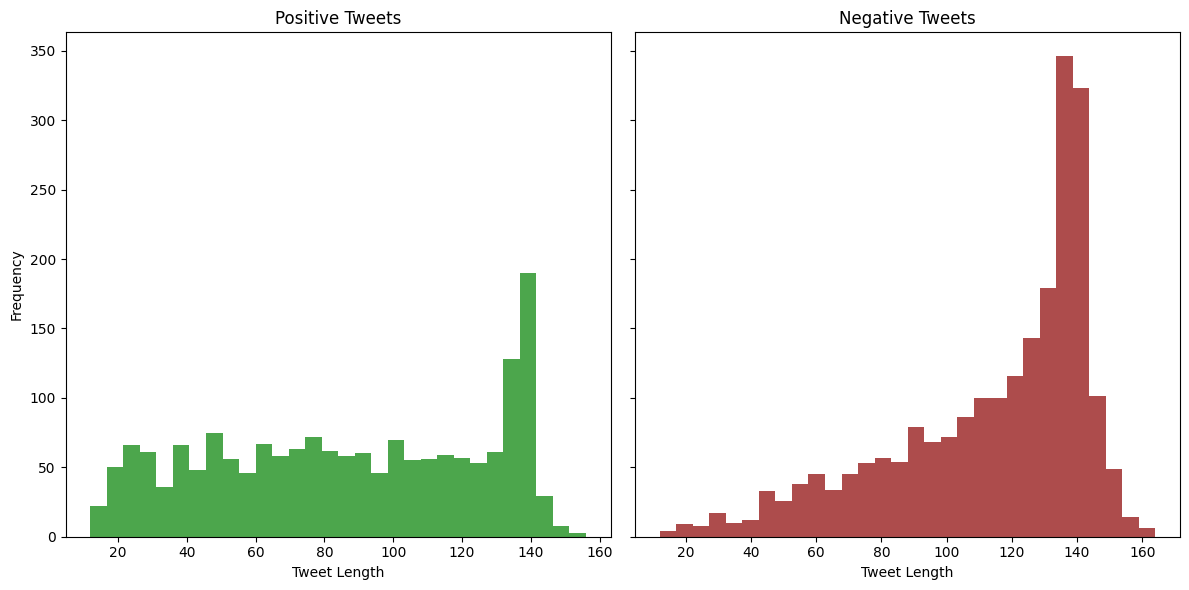

In [8]:
positive_tweets = train[train['airline_sentiment'] == 'positive']
negative_tweets = train[train['airline_sentiment'] == 'negative']

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot histogram for positive tweets
axes[0].hist(positive_tweets['text'].apply(len), bins=30, color='green', alpha=0.7)
axes[0].set_title('Positive Tweets')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('Frequency')

# Plot histogram for negative tweets
axes[1].hist(negative_tweets['text'].apply(len), bins=30, color='darkred', alpha=0.7)
axes[1].set_title('Negative Tweets')
axes[1].set_xlabel('Tweet Length')

# Show plot
plt.tight_layout()
plt.show()


**Histogram analysis:** Reviewing the plots above, we can see that the longest tweets are around 160 characters.  Additionally, it's interesting (and makes sense because people like to rant) that the negative tweets tend to be longer while the positive tweets are pretty evently distributed with a spike around 140 characters.

### Data cleaning & visualization

In [9]:
def clean_text(dataframe, text_col):
    '''
    A helper function which takes a dataframe 
    and removes punction and stopwords.
    '''
    # Remove all punctuation
    # r: denotes raw literal string 
    # [^\w\s]: match any character that is not word or whitespace
    # +: this quantifier matches one or more occurrences of the preceding character class [^\w\s]
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    # Remove numbers 
    # 0-9: matches any number
    dataframe['no_punct_num'] = dataframe['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    # Remove stopwords
    # Stopwords retrieved from ntlk (NLTK is a leading platform for building Python programs to work with human language data)
    # i.e., 'i', 'me', 'my', ..., 'he', 'him', 'his', ..., 'a', 'an', 'the', ..., 'why', 'how', 'all', etc.
    # Citation: https://www.nltk.org/
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    # Remove extra spaces
    # ' +': matches one or more consecutive spaces
    # ' ': this is the replacement string (one space)
    dataframe['clean_text'] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))
    return 

clean_text(train, 'text')
clean_text(test, 'text')

train.head()

,Id,airline_sentiment,airline,text,retweet_count,user_timezone,no_punct,no_punct_num,no_stopwords,clean_text
0,1450,negative,American,@AmericanAir thanks for the response. I know i...,0,NaN,AmericanAir thanks for the response I know its...,AmericanAir thanks for the response I know its...,AmericanAir thanks response I know fault But I...,AmericanAir thanks response I know fault But I...
1,7983,positive,US Airways,@USAirways I'm enjoying my flights so far! You...,0,London,USAirways Im enjoying my flights so far Youre ...,USAirways Im enjoying my flights so far Youre ...,USAirways Im enjoying flights far Youre great ...,USAirways Im enjoying flights far Youre great ...
2,6479,positive,United,Hey @united you've upgraded me on a 10 hour In...,0,Amsterdam,Hey united youve upgraded me on a 10 hour Inte...,Hey united youve upgraded me on a hour Intern...,Hey united youve upgraded hour International f...,Hey united youve upgraded hour International f...
3,2478,negative,United,"@united ""where we trick you into making us loo...",1,NaN,united where we trick you into making us look ...,united where we trick you into making us look ...,united trick making us look popular Twitter wo...,united trick making us look popular Twitter wo...
4,6366,positive,United,@united it was delivered! Thank you for making...,0,NaN,united it was delivered Thank you for making s...,united it was delivered Thank you for making s...,united delivered Thank making sure arrived doo...,united delivered Thank making sure arrived doo...


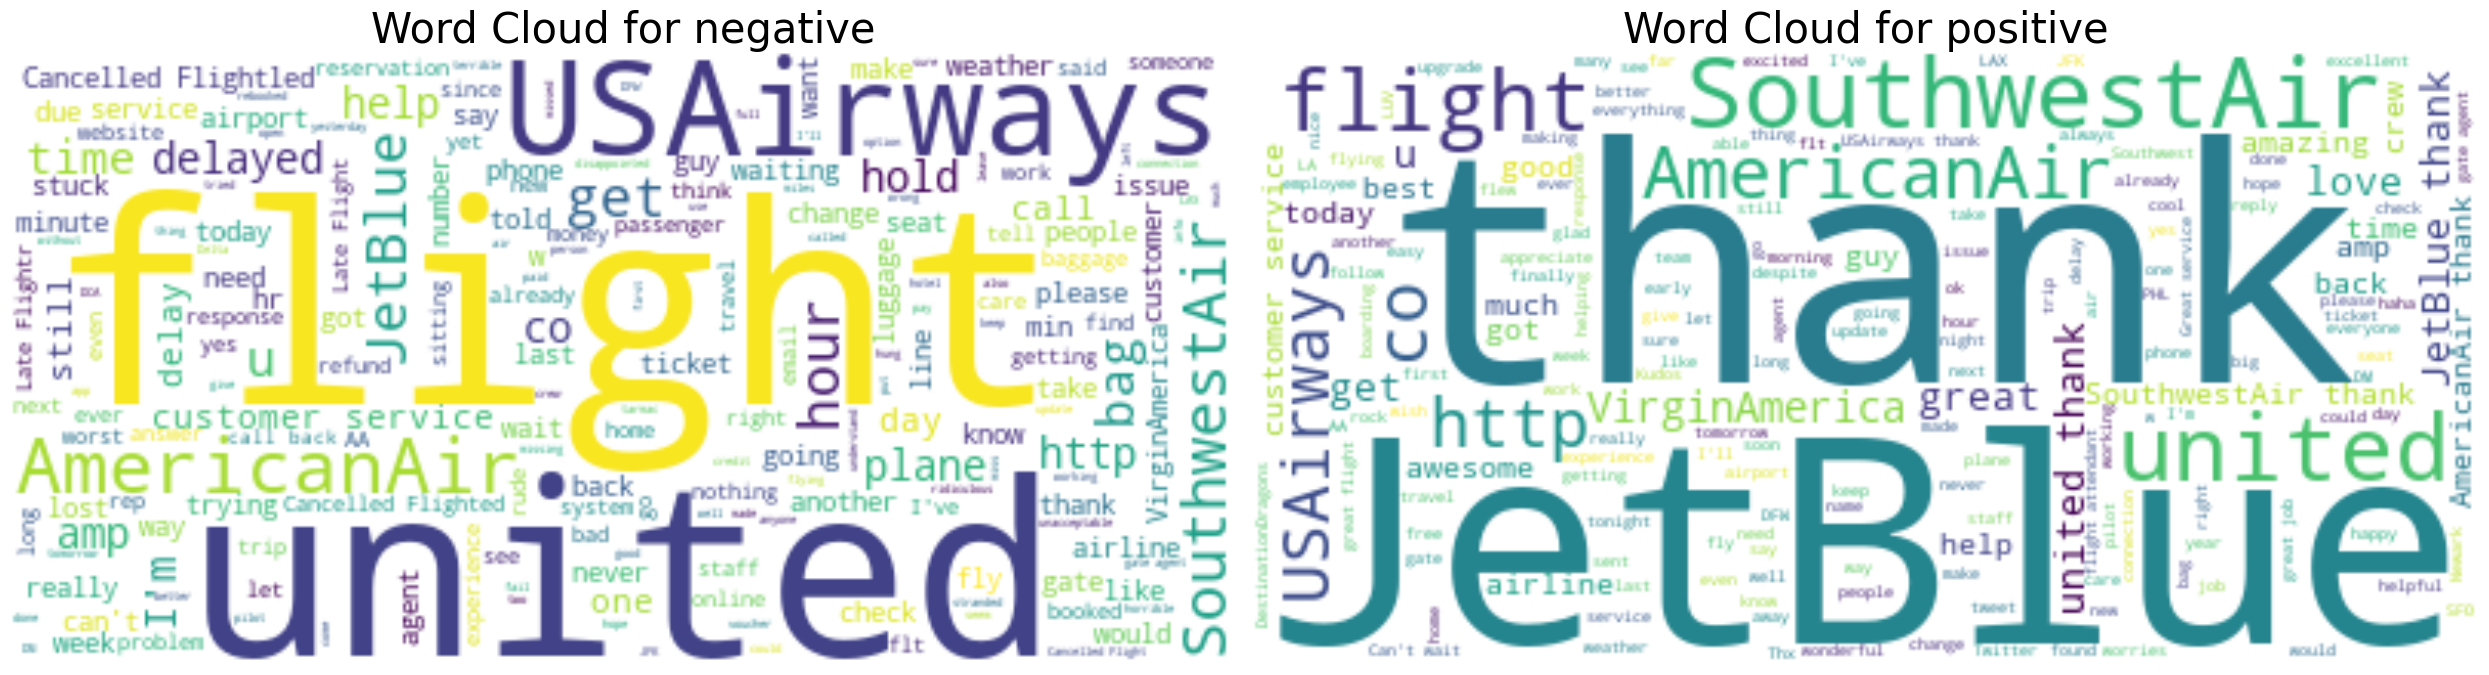

In [10]:
# Create some wordclouds to visualize the most common words
# Define the stopwords; Said was the one of the most common for all sentiments
stopwords = stopwords.words('english')
sentiments = train['airline_sentiment'].unique()

# Create a subplot for each category
fig, axes = plt.subplots(1, len(sentiments), figsize=(25, 10))

# Iterate over sentiments and generate word cloud for each
for i, category in enumerate(sentiments):
    # Filter the DataFrame for the current category
    sentiment_text = ' '.join(train[train['airline_sentiment'] == category]['text'])
    
    # Generate the word cloud, excluding stopwords
    wordcloud = WordCloud(width=400, height=200, background_color='white', stopwords=stopwords).generate(sentiment_text)
    
    # Display the word cloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for {category}', fontsize=30)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Visualizing the text:** Reviewing the two wordclouds above, the most common words are names which makes sense.  If we review a bit more closely, the positive has some good words that pop out such as "thank", "love", and "awesome".  The negative is a bit harder to pick out obvious words, but we can see "delayed", "cancelled", "refund" are all present.  

### Feature extraction
The next logical step is to attempt some feature extraction.  This is a necessary step for converting text documents into numerical feature bectors for machine learning models.  It will help us to see the importance of each term in the documents and allow the model to understand and learn from the data.  For this application I will use an approach known as Term Frequency, Inverse Document Frequency (TF-IDF).  This is a numerical statsistic used to evaluate the importance of a word in a document relative to a collection of documents.
<br><br>**Breaking down the steps:**
- Term frequency (TF) will measure how frequently the word appears in a document (number of occurrences in the document divided by total number of terms in the document) to measure the importance of the word
- Inverse document frequency (IDF) will measure how important a word is across the collection of documents (logarithm of the total number of documents divided by the number of documents containing the word).  For the less mathematically inclined (like me 😜) this means that the IDF of a given word actually *decreases* as the number of documents containing that word increases.  The logic is that a word that appears less frequently across all the documents is actually *more* important than ones that appear frequently
- Putting the above points together, term freqency - inverse document frequency (TF-IDF) provides a way to quantify the importance of a word in a document and still take into consideration all the other documents at the same time. This means a word with a high TF-IDF score in a document is frequent in that given document, but rare across the collection of other documents and is therefore important in this specific document (calculated with TF multiplied by IDF)

In [11]:
# Create TF-IDF vectorizer and fit it to the training data
train_bank = list(train["text"])
train_vectorizer = TfidfVectorizer()
train_res = train_vectorizer.fit_transform(train_bank).todense()

# Transform test data using the fitted vectorizer
# Note: we need to use the training vector to transform the test bank so that the 
#   number of features in the test dataset matches the number of features expected 
#   by the NMF model, which will be trained on the training dataset
test_bank = list(test["text"])
test_res = train_vectorizer.transform(test_bank).todense()

print(f"Matrix shapes: training = {train_res.shape}; testing = {test_res.shape}")

Matrix shapes: training = (4008, 7059); testing = (1355, 7059)


Now that we've applied TF-IDF, let's try the wordclouds again and see if we can spot any differences...

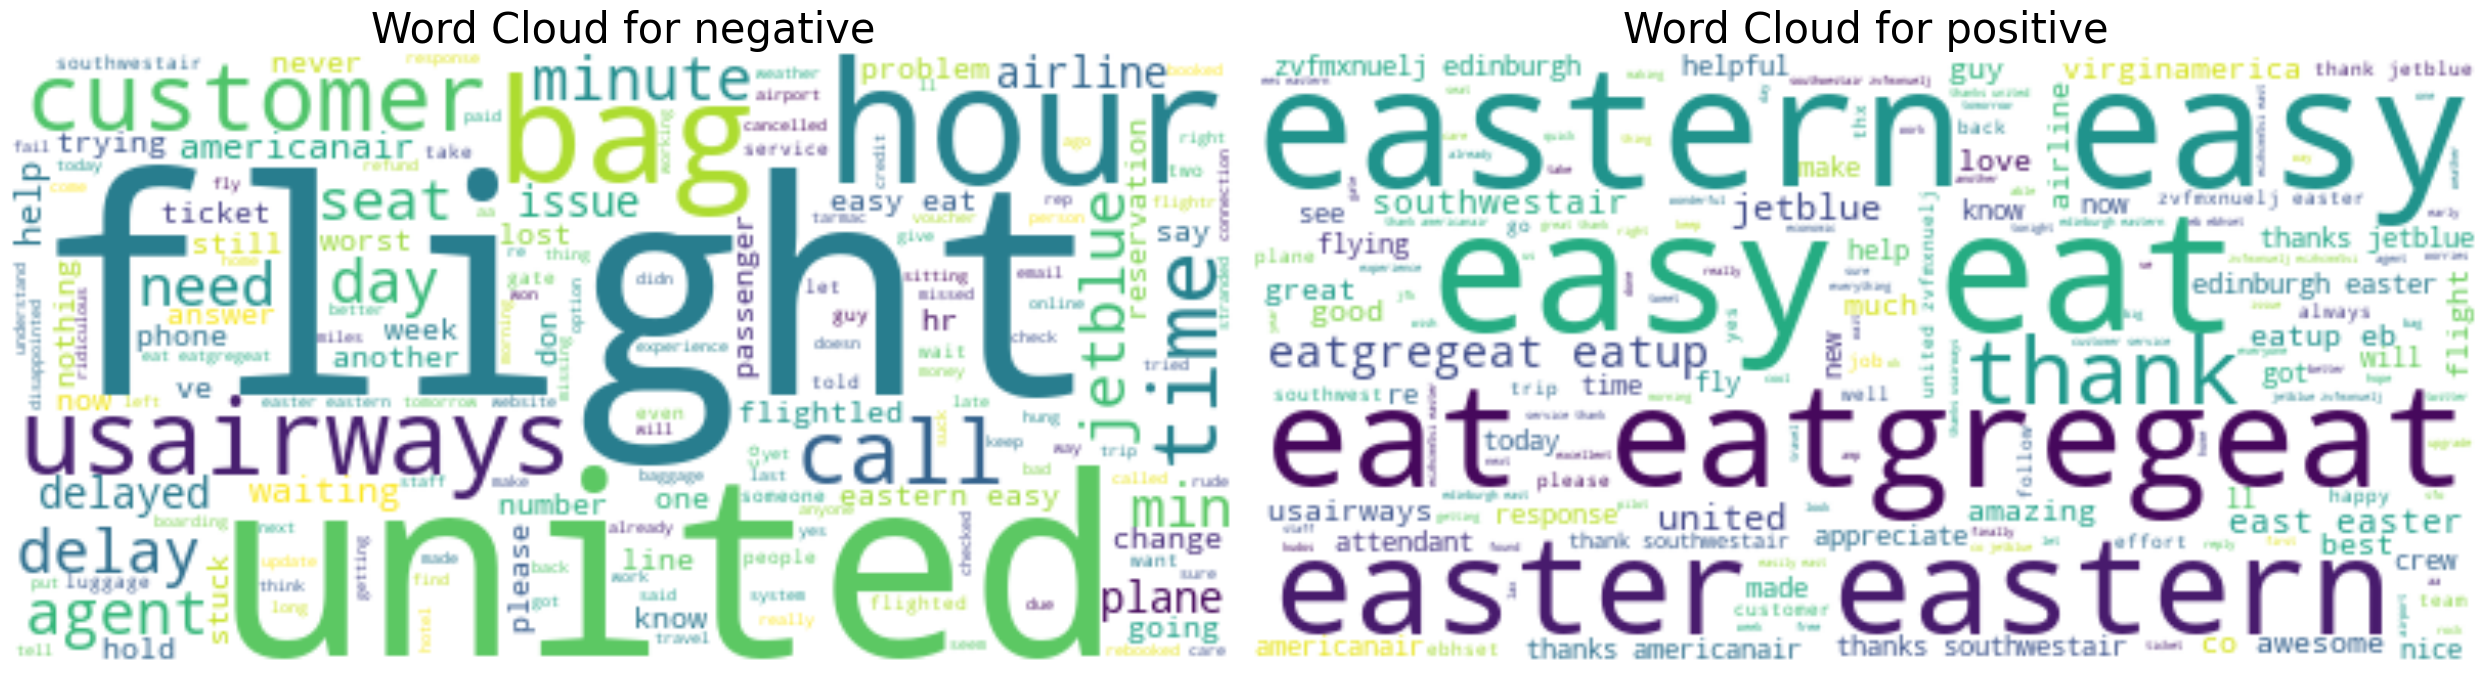

In [12]:
tfidf_feature_names = train_vectorizer.get_feature_names_out()
tfidf_feature_names = np.array(tfidf_feature_names)
train_text_after_tfidf = [" ".join(tfidf_feature_names[np.array(doc).argsort()[0, ::-1][:10]]) for doc in train_res]

# Get unique sentiments
sentiments = train['airline_sentiment'].unique()

# Create subplots for each sentiment
fig, axes = plt.subplots(1, len(sentiments), figsize=(25, 10))

# Generate word cloud for each sentiment
for i, sentiment in enumerate(sentiments):
    # Filter the training data for the current sentiment
    sentiment_indices = train[train['airline_sentiment'] == sentiment].index
    sentiment_text = " ".join([train_text_after_tfidf[idx] for idx in sentiment_indices])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(sentiment_text)
    
    # Display the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for {sentiment}', fontsize=30)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Visualizing the text:** The wordclouds have changed significantly and we can pull out some more obvious words especially for the negative cloud (this is the one we had to look closer at last time) such as 'delayed', 'problem', 'waiting', 'hour'.  The positive wordcloud has more evenly dispersed words compared to the last one such as 'easy', 'great', 'thank', 'amazing', 'love'.

## Step 2: Model creation & evaluation

For my model I will be using non-negative matrix factorization (NMF) to factorize our TF-IDF matrix into two non-negative matrices: W (the basis AKA weights matrix) and H (the coefficients matrix).  This should help us identify any patterns or representations.  Additionally, I will try to cluster the datapoints using Kmeans clustering.  This is an iterative optimization algorithm that partitions data into K clusters and tries to minimize the within-cluster variance or sum of squared distances between the datapoints and their centroids.  

In [13]:
train_res_np = np.asarray(train_res)
test_res_np = np.asarray(test_res)

# ------ Citation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html ------ #
# n_components = positive, negative
# init = nndsvd = NonNegative Double Singular Value Decomposition => better for spareness 
# beta_loss = Beta divergence to be minimized (kullback-leibler works better on this dataset than frobenius)
# max_iter = 3000
# solver = Multiplicative Update solver (instead of cd = Coordinate Descent solver)
# l1_ratio = The regularization mixing parameter
# -------------------------------------------------------------------------------------------------------- #

nmf_model = NMF(n_components=2, init='random', beta_loss = "frobenius", random_state=42) # => results in silhouette score = 0.8121752439986009
# nmf_model = NMF(n_components=2, init='random', beta_loss = "kullback-leibler", solver = 'mu', l1_ratio = 0.5, random_state=42) # => results in silhouette score = 0.5391279448635121 
# nmf_model = NMF(n_components = 2, init = 'nndsvd', beta_loss = "frobenius", max_iter= 3000, random_state=42) # => results in silhouette score = 0.7947584215712075
# nmf_model = NMF(n_components = 2, init = 'nndsvd', beta_loss = 'kullback-leibler', solver = 'mu', l1_ratio = 0.5, random_state=42) # => results in silhouette score = 0.6953945300641565 (also takes a long time)

# Fit NMF model to the TF-IDF transformed matrix
W = nmf_model.fit_transform(train_res_np)  # Basis matrix
W_test = nmf_model.transform(test_res_np)
H = nmf_model.components_ 

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(W_test)  

silhouette = silhouette_score(W_test, clusters)
print(f"The model scored a silhouette score of {round(silhouette, 5)}.")

c:\Users\maes2l\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The model scored a silhouette score of 0.81218.


**Silhouette scores:**

The silhouette score ranges between -1 and 1 and can be used to evaluate the quality of the clusters in an unsupervised learning algorithm.  A negative score indicates that the datapoints are assigned to the wrong clusters.  A score close to zero implies that the datapoints are very close to the decision boundary meaning the clusters are not well defined or are ambiguous.  A score closer to 1 indicates that the datapoints are well clustered and distinctly separated from the other clusters.

Citation: https://www.educative.io/answers/what-is-silhouette-score

Note: silhouette scores are commonly used for unsupervised learning algorithms because a metric like accuracy is not applicable.  Accuracy applies more to supervised learning algorithms where there is a ground truth label, however for unsupervised we are merely looking for patterns & trends in the data.

I have performed several iterations in the above model creation (see commented lines for code details) and extracted the silhouette scores, different configuration, and a couple additional notes in the table below for reference.

| Silhouette score | Details |
| --- | --- |
| 0.81218 | n_components = 2; init = random ; beta_loss = frobenius |
| 0.53913 | n_components = 2; init = random ; beta_loss = kullback-leibler ; Note: also takes noticeably longer than frobenius|
| 0.79476 | n_components = 2; init = nndsvd ; beta_loss = frobenius | 
| 0.6954  | n_components = 2; init = nndsvd ; beta_loss = kullback-leibler ; Note: also takes noticeably longer than frobenius|
| 0.46976 | n_components = 10; init = random ; beta_loss = frobenius |
| 0.45194 | n_components = 10; init = nndsvd ; beta_loss = frobenius | 


Next, to help us visualize the clusters, I have graphed the basic kmeans clusters.  I will also apply t-distributed Stochastic Neighbor Embedding (t-SNE) & principal component analysis (PCA).  These processes are commonly used for visualization even in cases where the dimensionality is already low because it can help reveal relationships in the data.

Citation: https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6

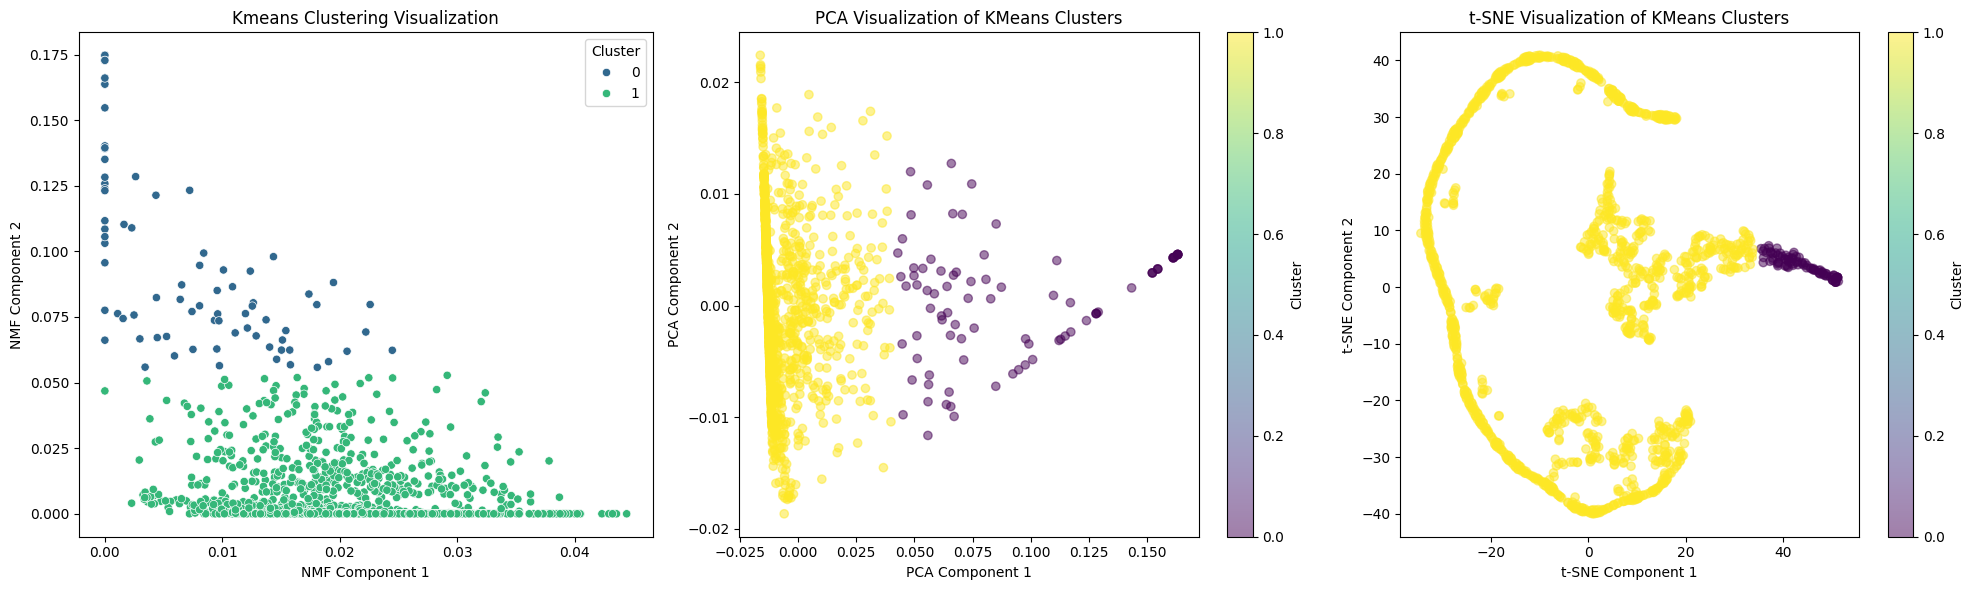

In [14]:
# Large plot for kmeans clusters, PCA on kmeans clusters, & t-SNE on kmeans clusters
plt.figure(figsize=(20, 6))

# Plot kmeans clusters without any dimension reduction assistance
plt.subplot(1, 3, 1)
sns.scatterplot(x=W_test[:, 0], y=W_test[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('Kmeans Clustering Visualization')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.legend(title='Cluster')

# Reduce dimensionality of the original data using PCA
pca = PCA(n_components=2)
W_pca = pca.fit_transform(W_test)

# Plot clusters colored by KMeans cluster assignments for PCA
plt.subplot(1, 3, 2)
plt.scatter(W_pca[:, 0], W_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')

# Reduce the dimensionality of the original data using t-SNE
tsne = TSNE(n_components=2, random_state=42)
W_tsne = tsne.fit_transform(W_test)

# Plot clusters colored by KMeans cluster assignments for t-SNE
plt.subplot(1, 3, 3)
plt.scatter(W_tsne[:, 0], W_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

We only have two applicable clusters, positive and negative sentiments.  Inspecting the visualizations, it seems like they have been divided only by a line and not necessarily clustered in the traditional sense.  

I'll try another method next, agglomerative clustering.  Compared to kmeans clustering, agglomerative clustering is more flexible since it doesn't require the number of clusters ahead of time.  It is a bottom-up hierarchical clustering method that starts with individual data points and gradually merges them into larger clusters.

In [15]:
nmf_model = NMF(n_components=2, init='random', beta_loss = "frobenius", random_state=42) # => results in silhouette score = 0.83719
# nmf_model = NMF(n_components=2, init='random', beta_loss = "kullback-leibler", solver = 'mu', l1_ratio = 0.5, random_state=42) # => results in silhouette score = 0.50574
# nmf_model = NMF(n_components = 2, init = 'nndsvd', beta_loss = "frobenius", max_iter= 3000, random_state=42) # => results in silhouette score = 0.82386
# nmf_model = NMF(n_components = 2, init = 'nndsvd', beta_loss = 'kullback-leibler', solver = 'mu', l1_ratio = 0.5, random_state=42) # => results in silhouette score = 0.6782

# Fit NMF model to the TF-IDF transformed matrix
W = nmf_model.fit_transform(train_res_np)  # Basis matrix
W_test = nmf_model.transform(test_res_np)
H = nmf_model.components_ 

agg_clustering = AgglomerativeClustering()  
clusters = agg_clustering.fit_predict(W_test)

silhouette = silhouette_score(W_test, clusters)
print(f"The model scored a silhouette score of {round(silhouette, 5)}.")

The model scored a silhouette score of 0.83719.


| Silhouette score | Details |
| --- | --- |
| 0.83719 | n_components = 2; init = random ; beta_loss = frobenius |
| 0.50574 | n_components = 2; init = random ; beta_loss = kullback-leibler ; Note: also takes noticeably longer than frobenius|
| 0.82386 | n_components = 2; init = nndsvd ; beta_loss = frobenius | 
| 0.6782  | n_components = 2; init = nndsvd ; beta_loss = kullback-leibler ; Note: also takes noticeably longer than frobenius|

The agglomerative clustering has performed slightly better than the best kmeans iteration, with a .83719 silhouette score (kmeans highest was 0.81218).  However, the visualizations don't appear to have changed much below, but with only two clusters perhaps there's not too much room to change.

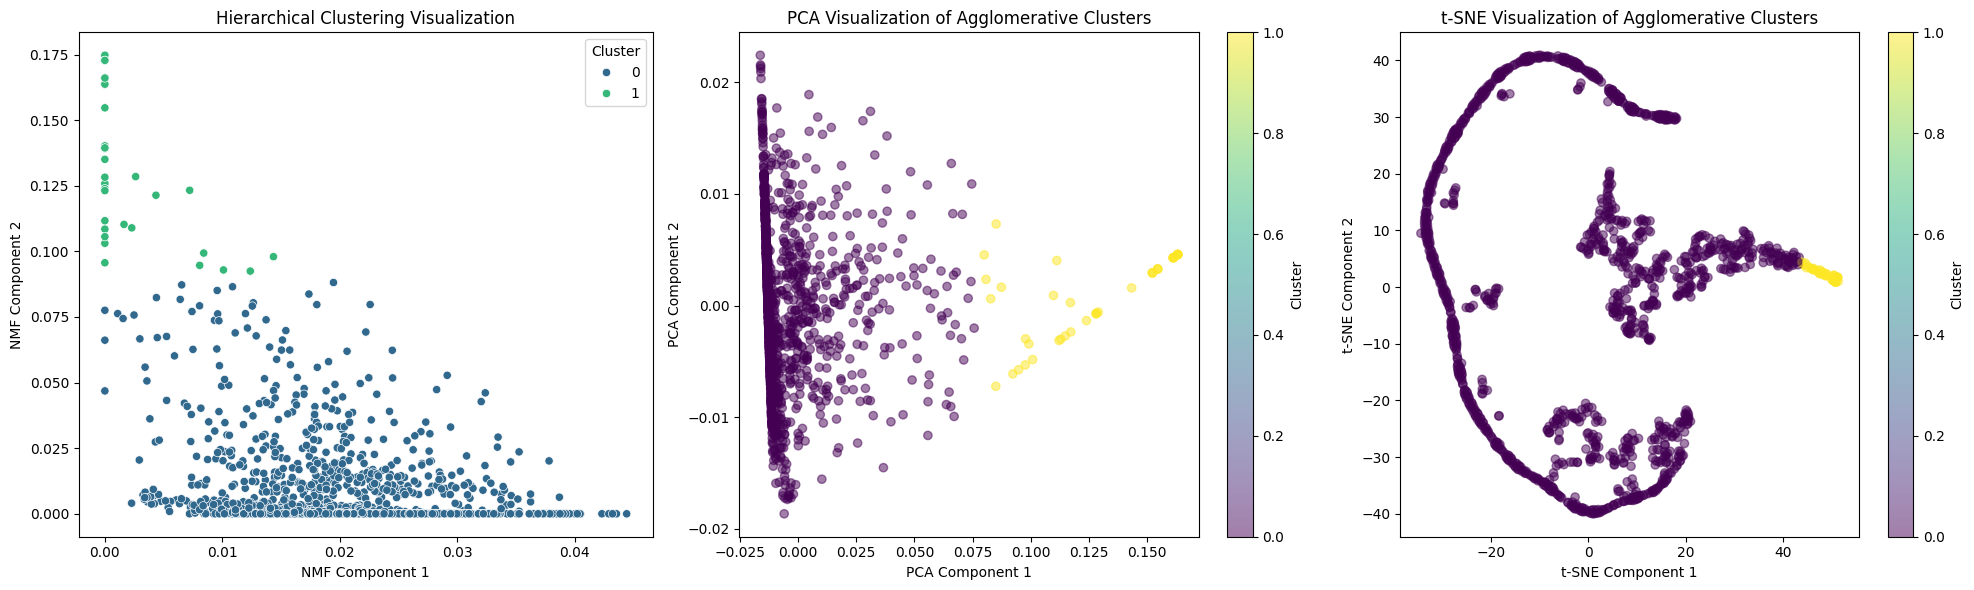

In [16]:
# Large plot for agglomerative clusters, PCA on agglomerative clusters, & t-SNE on agglomerative clusters
plt.figure(figsize=(20, 6))

# Plot agglomerative clusters without any dimension reduction assistance
plt.subplot(1, 3, 1)
sns.scatterplot(x=W_test[:, 0], y=W_test[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('Hierarchical Clustering Visualization')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.legend(title='Cluster')

# Reduce dimensionality of the original data using PCA
pca = PCA(n_components=2)
W_pca = pca.fit_transform(W_test)

# Plot clusters colored by agglomerative cluster assignments for PCA
plt.subplot(1, 3, 2)
plt.scatter(W_pca[:, 0], W_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Agglomerative Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')

# Reduce the dimensionality of the original data using t-SNE
tsne = TSNE(n_components=2, random_state=42)
W_tsne = tsne.fit_transform(W_test)

# Plot clusters colored by agglomerative cluster assignments for t-SNE
plt.subplot(1, 3, 3)
plt.scatter(W_tsne[:, 0], W_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Agglomerative Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

Finally, I will try one last clustering method, Density-Based Spatial Clustering of Applications with Noise (DBSCAN) which is useful for identifying clusters in spatial datasets with noise and outliers. It's designed for datasets with clusters of irregular shapes, so perhaps it will perform differently than the past couple of attempts.

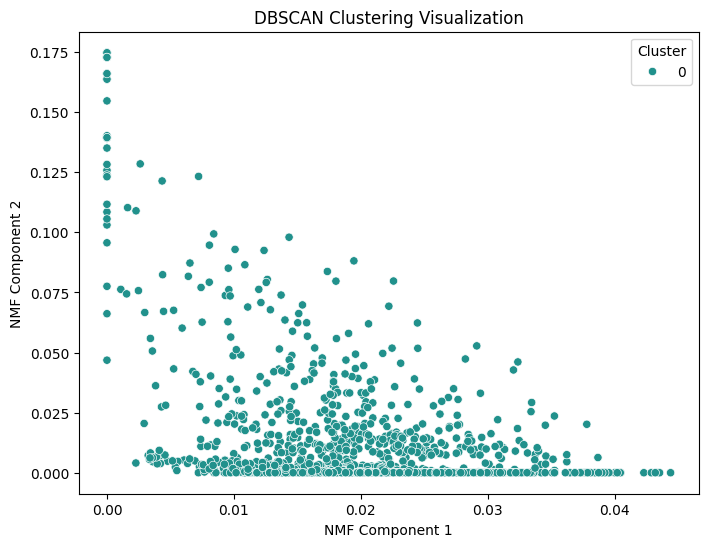

In [20]:
# Create DBSCAN instance
dbscan = DBSCAN(eps=9.7, min_samples=2)  

# Fit DBSCAN to the data
clusters = dbscan.fit_predict(W_test)

# silhouette = silhouette_score(W_test, clusters)
# print(f"The model scored a silhouette score of {round(silhouette, 5)}.")

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=W_test[:, 0], y=W_test[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('DBSCAN Clustering Visualization')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.legend(title='Cluster')
plt.show()


I tried several iterations of hyperparameter tuning, but I could only get one cluster out of DBSCAN.  We also can't measure any silhouette score for it since it's only identifying one cluster.  I did some reading and it seems one problem for DBSCAN might be if the data is uniformly distributed without distinct clusters, it can interpret everything as a single cluster.  I had already noticed that visibly there weren't any noticable clusters, so this is likely the problem.

Note: We are also unable to calculate any silhouette scoures since they require a minimum of 2 clusters

Citation: https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31

## Bonus: Compare with supervised learning method

As a bonus, I have also quickly build and trained a logistic regression model based on the TF-IDF feature extraction to see how it would perform.

In [21]:
# Build & train logistic regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(train_res_np, train['airline_sentiment'])

# Predict sentiments in test dataset
predicted_sentiments = logistic_regression_model.predict(test_res_np)
test['Category'] = predicted_sentiments

# Export to CSV for submitting to Kaggle
output_solutions = pd.DataFrame(test[['Id', 'Category']])
output_solutions.to_csv("./output.csv")

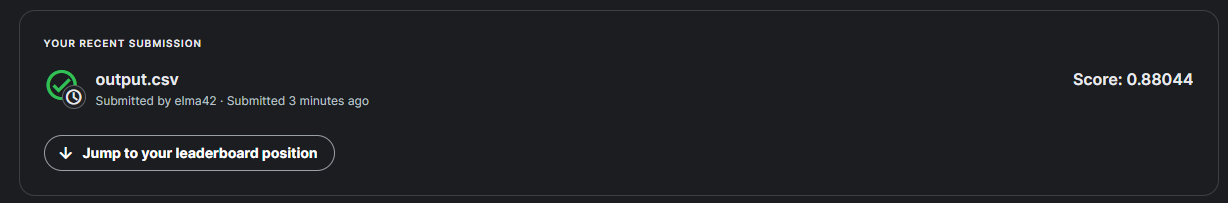

I have received a .88044 accuracy score from my submission to the kaggle competition which was higher than the top position on the leaderboard!  I'm pleased with the results as it shows that at least the TF-IDF approach is working well.

## Summary & Conclusion

Summary of steps, methods, & models attempted:
1. Data preprocessing & cleaning
2. Feature extraction via TF-IDF
3. Topic modeling with NMF
4. Unsupervised clustering models
    1. KMeans
    2. Agglomerative
    3. DBSCAN
5. Bonus: Compare with logistic regression supervised model 

It's difficult to compare this score to the clustering silhouette scores since they measure different aspects of model performance and are calculated differently. 
- For the unsupervised methods, the highest silhouette score I achieved was 0.81218 which on a range of -1 to 1 is quite high.  This means that the clusters formed by the agglomerative clustering method had a high degree of separation and cohesion and indicates that they performed pretty well in capturing the underlying structure of the data.  
- For my supervised approach, the accuracy score I achieved was .88044 meaning the model's prediction aligned well with the true sentiment of the labels in the test dataset. 

In the end, it depends on the application and the data available to you.  Because I had the option to submit the predicted labels, this could be treated as a supervised application, but if we didn't we would be forced to take an unsupervised approach.  Personally, I think the supervised method worked better because the visible clusters achieved through the unsupervised methods were not as densely clustered as I had hoped. 

Potential next steps: Apply futher text data analysis with Natural Language Processing (NLP).  Consider especially looking into named entity recognition to extract further insights from the text.  

Thank you for taking the time to review my project!

Liz

## Citations:

- https://www.kaggle.com/competitions/airbus-finance-ml-workshop/overview
- https://www.nltk.org/
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- https://www.educative.io/answers/what-is-silhouette-score
- https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31